# Seleção de Features

---

1. [O que é](#o-que-é)
2. [Filters](#filters)
    1) [Limiar de Variância](#limiar-de-variância)
    2) [KBest](#kbest)
3. [Intrinsic](#intrinsic)
4. [Wrapper](#wrapper)
5. [Referências](#referências)

## O que é

Seleção de _features_ é o processo em que _features_ são concientemente removidas do dataset para melhorar a qualidade dos dados. Por exemplo, _features_ redundantes podem ser removidas do dataset sem prejuízo. Beyer [1] mostra como uma quantidade maior de _features_ pode ser deletéria para classificação, especificamente com _kNN_. A depender da característica dos datasets, uma grande quatnidade de _features_ pode reduzir a variabilidade da medida da distância euclidiana.

Métodos de seleção de _features_ podem ser divididos em:

- _filter_: usam métodos estatísticos para seleção das melhores _features_.
- _intrinsic_: são métodos de seleção de features que acontecem intrisicamente nos classificadores. Podemos citar uma árvore de decisão como exemplo, caso a altura da árvore seja limitada, as melhores _features_ são escolhidas primeiro. Assim sendo, esse classificador possui uma seleção de features instrísica.
- _wrapper_: esses métodos criam vários classificadores, treinados em diferentes _features_, e a _features_ serão escolhidas a partir do melhor classificador.

Vamos criar um dataset de classificação. A função _make_classificaiton_ cria um dataset com 100 instancias, 4 features e apenas 2 features contém informção não-redundante propositalmente.

In [77]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100, n_features=4, n_informative=2, random_state=199)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=199)
df = pd.DataFrame(X, columns=[0, 1, 2, 3])

### Visualizando cada um dos pares de _features_



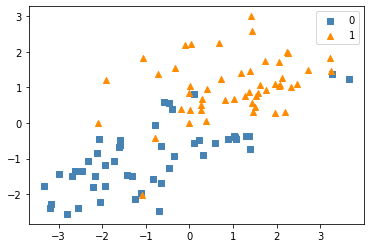

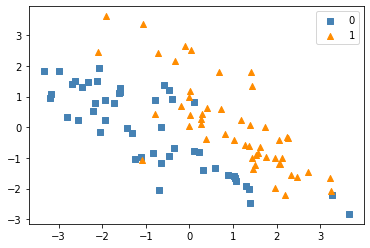

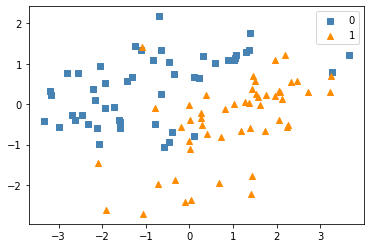

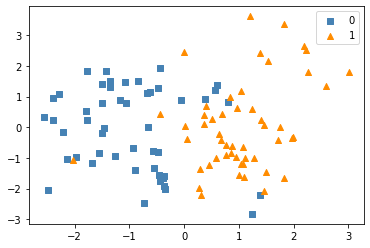

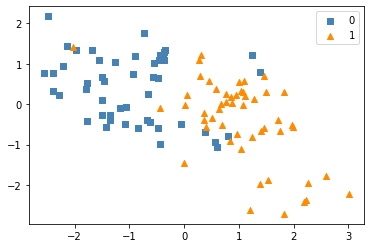

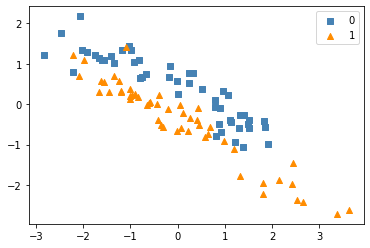

In [78]:
# Bibliotecas de manipualção e visualização de dados
import numpy as np
import matplotlib.pyplot as plt

# vamos definir cores e simbolos para nossas classses
colors = {0: "steelblue", 1: "darkorange", 2: "mediumseagreen"}
markers = {0: "s", 1: "^", 2:"o"}

# vamos criar uma função para visualizar uma região 2d, dadas duas features
def plot_2d_space(X, y, f1, f2, colors=colors, markers=markers):
    plt.figure()
    labels = list(np.unique(y))
    labels.sort()

    lines = []
    for i in labels:
        line = plt.scatter(
            X[f1][y==i],
            X[f2][y==i], 
            c=colors[i], 
            marker=markers[i],
            label=i,
        )

        lines.append(line)

    plt.legend(handles=lines)
        
    plt.show()

for i in range(4):
    for j in range(i+1, 4):
        plot_2d_space(df, y, i, j)

Observe que algumas combinações de features apresentam alguma repetição. Apesar de serem diferentes, o primeiro grafico e o segundo estão espelhados em $y$.

Assim, que métodos podemos usar para enfrentar esse problema?

## Filters

### Limiar de Variância

O limiar de variância é o método mais simples de seleção de _features_. Caso a _feature_ não tenha determinada variância, ela deve ser removida.

In [93]:
from sklearn.feature_selection import VarianceThreshold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

filter_variance = VarianceThreshold(0.8)
X_filtered = filter_variance.fit_transform(X)

# quantas features conseguimos remover?
print(X_filtered.shape)

(100, 4)


Perceba que das 4 _features_, nenhuma foi removida, mesmo com o filtro de variância para _features_ com $\sigma^2 > 0.8$. Esse tipo de método é util quando as _features_ são muito esparsas, como no caso de um dataset com _features_ binárias.

### KBest

Aqui escolhemos a quantidade de _features_ que serão escolhidas após um teste estatístico. O diagrama abaixo serve como base para a escolha do teste disponível no _sklearn_ baseado no tipo de variável de entrada e saída.


```
                                                    numérica - _r_regression_ (Pearson)
                                                   /
                      numérica - variável de saída
                     /                             \
                    /                                categórica - _f_classif_ (ANOVA)
variável de entrada 
                    \                                  numérica - _mutual_info_regression_ (Mutual Information)
                     \                               /
                       categórica - variável de saída
                                                     \
                                                       categórica - _mutual_info_classif_ (Mutual Information)
```

Cada uma dessas funções mede a correlação entre as features e a variável objetivo. Essas correlações são utilizadas para ranquear as melhores features, ou seja, as features são que são mais correlacionadas com a saída. Após isso, definimos o número de features a serem escolhidas.

In [103]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

kbest = SelectKBest(score_func=f_classif, k=2)
X_filtered = kbest.fit_transform(X, y)

# quantas features conseguimos remover?
print("Features selecionadas: %d" %(X_filtered.shape[1]))

Features selecionadas 2


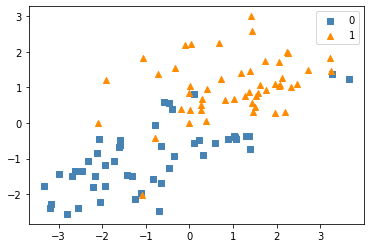

In [89]:
# visualizando as features selecionadas
df = pd.DataFrame(X_filtered, columns=[0, 1])
plot_2d_space(df, y, 0, 1)

## Intrinsic

Vamos relembrar a árvore de decisão. Esse classificador ranqueia as "melhores" features para serem utilizadas primeiro, objetivando a melhor separação. Podemos usar esse classificador para selecionar apenas as melhores features.

In [102]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier()
sfm = SelectFromModel(estimator=base_estimator)
X_filtered = sfm.fit_transform(X, y)

print("Features selecionadas: %d" %(X_filtered.shape[1]))

Features selecionadas: 1


Apenas uma feature foi selecionada... será que é suficiente?

In [100]:
print("Resultado com todas as features")
model = KNeighborsClassifier().fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

print("\nResultado com apenas as features selecionadas")
base_estimator = DecisionTreeClassifier()
sfm = SelectFromModel(estimator=base_estimator)
X_train_filtered = sfm.fit_transform(X_train, y_train)
X_test_filtered = sfm.transform(X_test)

model = KNeighborsClassifier().fit(X_train_filtered, y_train)
print(classification_report(y_test, model.predict(X_test_filtered)))


Resultado com todas as features
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.89      0.94      0.91        17

    accuracy                           0.90        30
   macro avg       0.90      0.89      0.90        30
weighted avg       0.90      0.90      0.90        30


Resultado com apenas as features selecionadas
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.89      0.94      0.91        17

    accuracy                           0.90        30
   macro avg       0.90      0.89      0.90        30
weighted avg       0.90      0.90      0.90        30



## Wrapper

Aqui, o processo de escolha de features depende de outros classificadores. Escolhemos um classificador linear, onde os coeficientes, ou medida de importância interna ao classificador, são utilizados para escolha das features mais importantes. Esse método é feito de forma recusriva, onde podemos controlar a quantidade de passos.

In [91]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

base_estimator = SVR(kernel="linear")
rfe = RFE(base_estimator, n_features_to_select=2, step=1)
X_filtered = rfe.fit_transform(X, y)

print(X_filtered.shape)

(100, 2)


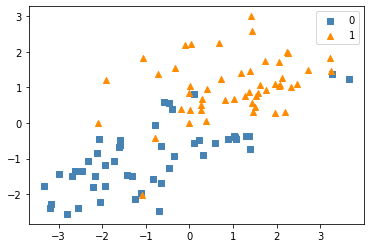

In [92]:
# visualizando as features selecionadas
df = pd.DataFrame(X_filtered, columns=[0, 1])
plot_2d_space(df, y, 0, 1)

## Referências

[1] [Beyer, Kevin, et al. "When is “nearest neighbor” meaningful?." International conference on database theory. Springer, Berlin, Heidelberg, 1999.](https://minds.wisconsin.edu/bitstream/handle/1793/60174/TR1377.pdf?sequence=1)